# Book Recommendation Agent with LangGraph

This notebook demonstrates a multi-agent book recommendation system with:
1. **Flexible matching** - Finds books even with fuzzy/partial titles
2. **Advanced retrieval** - BM25 + Multi-Query + Cohere Reranking
3. **Smart routing** - Vector search → Web search fallback → Similar books
4. **Clarification** - Asks for details when request is vague
5. **Personalization** - Considers age, interests, and whether it's a gift

## Setup

In [1]:
import os
import getpass
import nest_asyncio

# Enable nested async for Jupyter notebooks
nest_asyncio.apply()

# Set API keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")
os.environ["COHERE_API_KEY"] = getpass.getpass("Enter your Cohere API key: ")

## Load Data and Create Advanced Retrieval System

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import Qdrant
from langchain_core.documents import Document
import pandas as pd
import requests
from langchain_community.document_loaders import PyMuPDFLoader


# COMPLETED

STEP 1: LOADING DOCUMENTS
✅ Models created

📖 Loaded 353 pages from PDF
✅ Created 19 PDF chunks from 10 pages

📚 Loaded 3 books from CSV:
  1. 'The Time Machine' by H. G. Wells
  2. 'Careers in Focus' by Ferguson Publishing Company
  3. 'Space exploration' by Miller, Ron, Ron Miller

✅ Prepared 3 CSV documents

STEP 2: CREATING SEPARATE RETRIEVERS

🔧 Building CSV Retriever...
✅ CSV Retriever created!
   - BM25 keyword matching
   - Multi-query retrieval
   - Cohere reranking

🔧 Building PDF Retriever...
✅ PDF Retriever created!
   - BM25 keyword matching
   - Multi-query retrieval
   - Cohere reranking

STEP 3: BUILDING AGENT WITH ROUTING

✅ Intelligent Routing Agent Created!

Routing Logic:
  📚 CSV Retriever → For book catalog queries
  📖 PDF Retriever → For Thief of Sorrows content queries
  🔍 Combined → For queries needing both sources

✅ Configuration ready

STEP 4: TESTING ROUTING SYSTEM
GRAPH VISUALIZATION


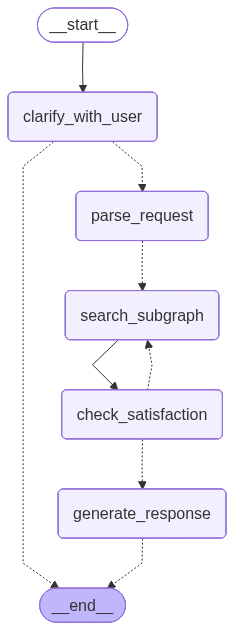

In [18]:
"""
Complete Notebook Integration Code
Sets up separate retrievers for CSV and PDF, then builds the intelligent routing agent
"""

import os
import pandas as pd
from langchain_core.documents import Document
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Qdrant
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.retrievers import BM25Retriever

# ============================================================================
# STEP 1: Load and Prepare Documents
# ============================================================================

print("="*60)
print("STEP 1: LOADING DOCUMENTS")
print("="*60)

# Initialize models
chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    max_tokens=1000
)

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
print("✅ Models created\n")

# ============================================================================
# Load PDF (Thief of Sorrows)
# ============================================================================

path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
pdf_pages = loader.load()

book_title = "Thief of Sorrows"
author = "Kristen Long"

print(f"📖 Loaded {len(pdf_pages)} pages from PDF")

# Add metadata to PDF pages
for i, page in enumerate(pdf_pages):
    page.metadata.update({
        "book_title": book_title,
        "author": author,
        "source_type": "pdf_fulltext",
        "has_full_text": True,
        "page_number": i + 1,
        "total_pages": len(pdf_pages),
    })

# Chunk PDF with semantic chunker
semantic_chunker = SemanticChunker(
    embeddings=embedding_model,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=95,
    buffer_size=5,
    add_start_index=True
)

# Process first 10 pages for testing (adjust as needed)
test_pages = pdf_pages[:10]
pdf_chunks = semantic_chunker.split_documents(test_pages)
print(f"✅ Created {len(pdf_chunks)} PDF chunks from {len(test_pages)} pages\n")

# ============================================================================
# Load CSV (Book Catalog)
# ============================================================================

df = pd.read_csv("space_exploration_books.csv")

print(f"📚 Loaded {len(df)} books from CSV:")
for i, row in df.iterrows():
    print(f"  {i+1}. '{row['title']}' by {row['author']}")
print()

# Convert CSV to documents
csv_documents = []
for index, row in df.iterrows():
    book_text = f"""Title: {row['title']}
Author: {row['author']}
Work Key: {row['work_key']}

Description: {row['description']}

Subjects: {row['subjects']}
"""
    
    metadata = {
        "title": row['title'],
        "author": row['author'],
        "work_key": row['work_key'],
        "subjects": row['subjects'],
        "source_type": "csv_metadata",
        "has_full_text": False,
        "row_index": index
    }
    
    doc = Document(page_content=book_text.strip(), metadata=metadata)
    csv_documents.append(doc)

print(f"✅ Prepared {len(csv_documents)} CSV documents\n")

# ============================================================================
# STEP 2: Create Separate Vector Stores and Retrievers
# ============================================================================

print("="*60)
print("STEP 2: CREATING SEPARATE RETRIEVERS")
print("="*60)

# ============================================================================
# CSV Retriever (Book Catalog Metadata)
# ============================================================================

print("\n🔧 Building CSV Retriever...")

# Vector store for CSV
csv_vectorstore = Qdrant.from_documents(
    documents=csv_documents,
    embedding=embedding_model,
    location=":memory:",
    collection_name="csv_catalog"
)

# BM25 for keyword matching
csv_bm25 = BM25Retriever.from_documents(csv_documents)
csv_bm25.k = 5

# Multi-query retriever
csv_multi_query = MultiQueryRetriever.from_llm(
    retriever=csv_vectorstore.as_retriever(search_kwargs={"k": 10}),
    llm=chat_model
)

# Reranking
csv_compression = ContextualCompressionRetriever(
    base_retriever=csv_multi_query,
    base_compressor=CohereRerank(model="rerank-v3.5")
)

# Ensemble retriever for CSV
csv_ensemble = EnsembleRetriever(
    retrievers=[csv_bm25, csv_multi_query, csv_compression],
    weights=[0.2, 0.3, 0.5]
)

print("✅ CSV Retriever created!")
print("   - BM25 keyword matching")
print("   - Multi-query retrieval")
print("   - Cohere reranking")

# ============================================================================
# PDF Retriever (Thief of Sorrows Full Text)
# ============================================================================

print("\n🔧 Building PDF Retriever...")

# Vector store for PDF
pdf_vectorstore = Qdrant.from_documents(
    documents=pdf_chunks,
    embedding=embedding_model,
    location=":memory:",
    collection_name="pdf_fulltext"
)

# BM25 for keyword matching
pdf_bm25 = BM25Retriever.from_documents(pdf_chunks)
pdf_bm25.k = 5

# Multi-query retriever
pdf_multi_query = MultiQueryRetriever.from_llm(
    retriever=pdf_vectorstore.as_retriever(search_kwargs={"k": 10}),
    llm=chat_model
)

# Reranking
pdf_compression = ContextualCompressionRetriever(
    base_retriever=pdf_multi_query,
    base_compressor=CohereRerank(model="rerank-v3.5")
)

# Ensemble retriever for PDF
pdf_ensemble = EnsembleRetriever(
    retrievers=[pdf_bm25, pdf_multi_query, pdf_compression],
    weights=[0.2, 0.3, 0.5]
)

print("✅ PDF Retriever created!")
print("   - BM25 keyword matching")
print("   - Multi-query retrieval")
print("   - Cohere reranking")

# ============================================================================
# STEP 3: Build the Intelligent Routing Agent
# ============================================================================

print("\n" + "="*60)
print("STEP 3: BUILDING AGENT WITH ROUTING")
print("="*60)

from book_research.book_agent import build_book_agent

# Build agent with both retrievers
book_agent = build_book_agent(
    csv_retriever=csv_ensemble,
    pdf_retriever=pdf_ensemble
)

print("\n✅ Intelligent Routing Agent Created!")
print("\nRouting Logic:")
print("  📚 CSV Retriever → For book catalog queries")
print("  📖 PDF Retriever → For Thief of Sorrows content queries")
print("  🔍 Combined → For queries needing both sources")

# Configuration
config = {
    "configurable": {
        "chat_model": "gpt-4o-mini",
        "max_tokens": 1000,
        "temperature": 0.5,
        "allow_clarification": False,
        "max_web_search_results": 3,
        "openai_api_key": os.environ["OPENAI_API_KEY"],
    }
}

print("\n✅ Configuration ready\n")

# ============================================================================
# STEP 4: Test the Routing System
# ============================================================================

print("="*60)
print("STEP 4: TESTING ROUTING SYSTEM")
print("="*60)

async def test_routing_scenarios():
    """Test different query types to demonstrate routing."""
    
    test_cases = [
        {
            "query": "What books about space exploration do you have?",
            "expected_route": "csv_metadata",
            "description": "Catalog query → Should search CSV"
        },
        {
            "query": "Tell me about the plot of Thief of Sorrows",
            "expected_route": "pdf_fulltext",
            "description": "Content query → Should search PDF"
        },
        {
            "query": "Do you have The Time Machine?",
            "expected_route": "csv_metadata",
            "description": "Specific book check → Should search CSV"
        },
        {
            "query": "What happens in chapter 2 of Thief of Sorrows?",
            "expected_route": "pdf_fulltext",
            "description": "Chapter content → Should search PDF"
        },
        {
            "query": "Books similar to Thief of Sorrows",
            "expected_route": "both",
            "description": "Similarity query → Should search BOTH"
        },
{
            "query": "Write a post about Thief of Sorrows",
            "expected_route": "write_post",
            "description": "Post creation → Should route to post_writing_agent"
        }    ]
    
    for i, test in enumerate(test_cases, 1):
        print(f"\n{'='*60}")
        print(f"TEST {i}: {test['description']}")
        print(f"{'='*60}")
        print(f"Query: \"{test['query']}\"")
        print(f"Expected Route: {test['expected_route']}")
        print()
        
        result = await book_agent.ainvoke(
            {"messages": [{"role": "user", "content": test['query']}]},
            config
        )
        
        # Extract routing info from messages
        routing_msg = None
        for msg in result.get("messages", []):
            content = msg.content if hasattr(msg, 'content') else msg.get('content', '')
            if "Routing:" in content:
                routing_msg = content
                break
        
        if routing_msg:
            print(f"🧭 {routing_msg}")
        
        print("\n📝 Response:")
        print("-" * 60)
        response = result.get("final_response", "No response")
        print(response[:300] + "..." if len(response) > 300 else response)
        print()


# ============================================================================
# STEP 5: Quick Test Functions
# ============================================================================

async def quick_test_csv():
    """Quick test: CSV catalog search"""
    result = await book_agent.ainvoke(
        {"messages": [{"role": "user", "content": "What books do you have about careers?"}]},
        config
    )
    print("\n" + "="*60)
    print("CSV SEARCH RESULT")
    print("="*60)
    print(result.get("final_response", "No response"))
    return result


async def quick_test_pdf():
    """Quick test: PDF content search"""
    result = await book_agent.ainvoke(
        {"messages": [{"role": "user", "content": "Tell me about Thief of Sorrows"}]},
        config
    )
    print("\n" + "="*60)
    print("PDF SEARCH RESULT")
    print("="*60)
    print(result.get("final_response", "No response"))
    return result


async def quick_test_specific_book():
    """Quick test: Specific book lookup"""
    result = await book_agent.ainvoke(
        {"messages": [{"role": "user", "content": "I want to find The Time Machine"}]},
        config
    )
    print("\n" + "="*60)
    print("SPECIFIC BOOK SEARCH RESULT")
    print("="*60)
    print(result.get("final_response", "No response"))
    return result


# ============================================================================
# VISUALIZATION
# ============================================================================

try:
    from IPython.display import Image, display
    print("="*60)
    print("GRAPH VISUALIZATION")
    print("="*60)
    display(Image(book_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")


# =================

In [4]:
await test_routing_scenarios()


TEST 1: Catalog query → Should search CSV
Query: "What books about space exploration do you have?"
Expected Route: csv_metadata

🧭 🧭 Routing: The query is asking for available books about space exploration, which falls under the request for catalog/available books. → csv_metadata

📝 Response:
------------------------------------------------------------
Here are some book recommendations focused on space exploration:

1. **Space Exploration**  
   **Author:** Ron Miller  
   **Description:** For hundreds of years, scientists have sought and studied new worlds beyond Earth. Author Ron Miller describes the long, hard trek from the first tentative att...


TEST 2: Content query → Should search PDF
Query: "Tell me about the plot of Thief of Sorrows"
Expected Route: pdf_fulltext

🧭 🧭 Routing: The query asks for information about the plot of 'Thief of Sorrows', which indicates a need for the full text of the book to provide detailed content. → pdf_fulltext

📝 Response:
----------------------

In [3]:
import asyncio

# Test queries that should trigger post writing
async def test_post_generator():
    """Test the social media post generation feature"""
    
    # Test queries that should route to post_writing_agent
    test_queries = [
        "Write a post about Thief of Sorrows",
        "Create a social media post for Thief of Sorrows",
        "Write about Thief of Sorrows for social media",
        "Can you create a post about the book Thief of Sorrows?",
        "I need a social media post about Thief of Sorrows"
    ]
    
    for query in test_queries:
        print("\n" + "="*70)
        print(f"TEST QUERY: {query}")
        print("="*70)
        
        result = await book_agent.ainvoke(
            {"messages": [{"role": "user", "content": query}]},
            config
        )
        
        # Check routing
        for msg in result.get("messages", []):
            content = msg.content if hasattr(msg, 'content') else msg.get('content', '')
            if "Routing:" in content:
                print(f"🧭 {content}")
        
        # Get the final post
        final_response = result.get("final_response", "No response")
        print("\n📱 GENERATED POST:")
        print(final_response)
        
        # Optional: Check if it actually routed to write_post
        search_results = result.get("search_results", {})
        if search_results.get("search_target") == "write_post":
            print("\n✅ Successfully routed to post_writing_agent!")
        else:
            print(f"\n⚠️ Routed to: {search_results.get('search_target')}")
        
        break  # Remove this to test all queries

# Run the test
await test_post_generator()


TEST QUERY: Write a post about Thief of Sorrows


c:\Users\nickm\Documents\AI08\10_Open_DeepResearch\book_research\book_agent.py:164: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = pdf_retriever.get_relevant_documents("plot themes characters quotes")


🧭 🧭 Routing: The query explicitly asks to 'write a post about Thief of Sorrows', which matches the criteria for routing to create a social media post. → write_post

📱 GENERATED POST:
📚✨ **Exploring "Thief of Sorrows"** ✨📚

"Thief of Sorrows" is a captivating journey through the depths of human emotion and the complexities of grief. This poignant narrative delves into the lives of characters who face loss in various forms, each grappling with their own sorrow while seeking solace and understanding. 

The author masterfully weaves together moments of despair and hope, illustrating how love can be both a source of pain and a beacon of light. As readers, we are invited to reflect on our own experiences with loss and the ways we navigate the intricate tapestry of life.

Whether you’re a fan of literary fiction or simply seeking a story that resonates on a deeper level, "Thief of Sorrows" is a must-read that will leave you contemplating the bittersweet nature of existence long after the fina

## EVALUATION

In [49]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [50]:
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
pdf_dataset = generator.generate_with_langchain_docs(pdf_chunks, testset_size=20, query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1.0)

],)

Applying SummaryExtractor:   0%|          | 0/8 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/19 [00:00<?, ?it/s]

Node c9a77a33-eb88-461c-b764-d421ed1d57d6 does not have a summary. Skipping filtering.
Node 205011b3-1574-48f5-8cea-a452aa8298b0 does not have a summary. Skipping filtering.
Node 4779c0cf-b89d-432f-a1e3-436fe7d2c003 does not have a summary. Skipping filtering.
Node a913de81-3446-4bde-b7b7-349fcc08cc3f does not have a summary. Skipping filtering.
Node 37cf4d16-8d0b-4779-aa46-b4a420974c6d does not have a summary. Skipping filtering.
Node 58db8e6d-6bdf-4551-9685-a3ac03a41fd7 does not have a summary. Skipping filtering.
Node 58028fec-0d3f-4b21-9671-d6d7fdaaacab does not have a summary. Skipping filtering.
Node 1831cf6a-01d5-4640-b1ce-b7e009887adb does not have a summary. Skipping filtering.
Node cad546a6-4407-447c-978c-b6ded6fe37d1 does not have a summary. Skipping filtering.
Node 0bc824b6-f4ea-44b7-a57e-b821c750dfdb does not have a summary. Skipping filtering.
Node 7490e2c4-b2e8-4459-9051-71d6b6c7f4cb does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/46 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
pdf_dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Whoo is Kristen M. and wut is her conection to...,[Thief of Sorrows © 2023 by Kristen M. Long\nM...,Kristen M. is credited as the author of Thief ...,single_hop_specifc_query_synthesizer
1,Whoo is Kristen M. Long in relashun to Thief o...,[Thief of Sorrows © 2023 by Kristen M. Long\nM...,Kristen M. Long is the author of Thief of Sorr...,single_hop_specifc_query_synthesizer
2,Who is Alice Maria Power in relation to the bo...,[Long\nTHIEF OF SORROWS\nCover Illustration: A...,Alice Maria Power is credited as the cover ill...,single_hop_specifc_query_synthesizer
3,What information is available about www.kriste...,[Long\nTHIEF OF SORROWS\nCover Illustration: A...,The context lists www.kristenmlong.com as part...,single_hop_specifc_query_synthesizer
4,What does the book mention about PTSD?,[Content Warning\nPlease be aware that this bo...,The book contains scenes involving PTSD.,single_hop_specifc_query_synthesizer
5,"what is ptsd mean in this book, why it say that",[Content Warning\nPlease be aware that this bo...,PTSD in this book mean it got scenes where peo...,single_hop_specifc_query_synthesizer
6,Who is Kamden in the story?,"[For Kamden,\nThe heart and soul of this story...",Kamden is described as the heart and soul of t...,single_hop_specifc_query_synthesizer
7,Who is Kamden in the context of this story?,"[For Kamden,\nThe heart and soul of this story...",Kamden is described as the heart and soul of t...,single_hop_specifc_query_synthesizer
8,what arnoria look like on map?,[Map of Arnoria],Map of Arnoria,single_hop_specifc_query_synthesizer
9,"what arnoria look like and where it at, i need...",[Map of Arnoria],Map of Arnoria,single_hop_specifc_query_synthesizer


In [52]:
for test_row in pdf_dataset:
 response = await book_agent.ainvoke({
        "messages": [{"role": "user", "content": test_row.eval_sample.user_input}]
    })
test_row.eval_sample.response = response.get("final_response", str(response))
search_results = response.get("search_results", {})
books = search_results.get("books", [])
retrieved_contexts = []
for book in books:
      if "content" in book: 
          retrieved_contexts.append(book["content"])
      elif "description" in book:
          retrieved_contexts.append(f"Title: {book.get('title')}\nAuthor: {book.get('author')}\n{book.get('description')}")
      else:
          retrieved_contexts.append(str(book))

test_row.eval_sample.retrieved_contexts = retrieved_contexts

In [63]:
for s in pdf_dataset:
        if hasattr(s, "eval_sample"):
            print(s.eval_sample.response)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
{'messages': [HumanMessage(content='What is the current state of Foxclove manor?', additional_kwargs={}, response_metadata={}, id='2a2a6927-ba46-4a2a-b9ef-846b47ed6c37'), AIMessage(content="Are you asking about a specific book titled 'Foxclove Manor' or are you looking for information or recommendations related to a theme or genre involving manors?", additional_kwargs={}, response_metadata={}, id='3b424916-0870-4b50-8ef6-4053a83b7712')]}


In [ ]:
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness,
)
import pandas as pd


def reset_eval_fields(ds):
    for s in ds:
        if hasattr(s, "eval_sample"):
            s.eval_sample.response = ""
            s.eval_sample.retrieved_contexts = []

def evaluate_current_dataset(ds, evaluator_llm):
    df = ds.to_pandas()

    # Clean response - replace NaN/None with default
    df['response'] = df['response'].fillna("No response generated")

    # Clean retrieved_contexts - handle NaN, None, empty lists
    def clean_contexts(val):
        # Check if NaN or None
        if val is None or (isinstance(val, float) and pd.isna(val)):
            return ["No contexts retrieved"]
        # Check if it's a list
        elif isinstance(val, list):
            return val if len(val) > 0 else ["No contexts retrieved"]
        # Convert other types to list
        else:
            return [str(val)]

    df['retrieved_contexts'] = df['retrieved_contexts'].apply(clean_contexts)

    evaluation_dataset = EvaluationDataset.from_pandas(df)
    return evaluate(
        dataset=evaluation_dataset,
        metrics=[
            LLMContextRecall(), Faithfulness(), FactualCorrectness()
        ],
        llm=evaluator_llm,
        run_config=RunConfig(timeout=360),
        raise_exceptions=False,
    )

In [68]:
res_ensemble = evaluate_current_dataset(pdf_dataset, generator_llm)
print(res_ensemble)

ValueError: The truth value of an empty array is ambiguous. Use `array.size > 0` to check that an array is not empty.

In [ ]:
%pip install langchain
%pip install langchain_community
%pip install langchain.text_splitter
%pip install  pymupdf
%pip install qdrant-client

  Using cached langchain_community-0.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached sqlalchemy-2.0.44-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.11.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
  Using cached greenlet-3.2.4-cp313-cp313-win_amd64.whl.metadata (4.2 kB)
  Using cached mypy_extensions-1.1.0-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------------------- ------------------- 1.3/2.5 MB

In [3]:
%pip install ragas

  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
  Using cached typer-0.19.2-py3-none-any.whl.metadata (16 kB)
  Using cached instructor-1.11.3-py3-none-any.whl.metadata (11 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached scikit_network-0.33.3-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached docstring_parser-0.17.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_openai-1.

In [ ]:
from book_research.simple_pdf_retriever import create_simple_pdf_retriever
retriever = create_simple_pdf_retriever("book_research/data/thief_of_sorrows.pdf")


[INIT] Loading PDF: book_research/data/thief_of_sorrows.pdf
[INIT] Created 970 chunks
[OK] PDF retriever ready!


In [ ]:
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness,
)

def evaluate_current_dataset(ds, evaluator_llm):
    evaluation_dataset = EvaluationDataset.from_pandas(ds.to_pandas())
    return evaluate(
        dataset=evaluation_dataset,
        metrics=[
            LLMContextRecall(), Faithfulness(), FactualCorrectness()
        ],
        llm=evaluator_llm,
        run_config=RunConfig(timeout=360),
        raise_exceptions=False,
    )

evaluator_llm = LangchainLLMWrapper(chat_model)


reset_eval_fields(dataset)
for row in dataset:
    q = getattr(row.eval_sample, "user_input", None) or getattr(row.eval_sample, "question", None)
    if not q: 
        continue
    out = naive_chain.invoke({"question": q})
    row.eval_sample.response = to_text(out["response"])
    row.eval_sample.retrieved_contexts = [d.page_content for d in out["context"]][:10]

# 3) Evaluate
res_naive = evaluate_current_dataset(dataset, evaluator_llm)
print(res_naive)

c:\Users\nickm\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
